In [1]:
import cv2, sys, os, time
import numpy as np
import pickle
import matplotlib.pyplot as plt 

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from utils.detection_tools import extract_object_and_background_masks
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import rectify_horizon, downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr
from utils.common_tools import find_nonzero_bounding_box, trim_video, draw_parallel_lines

from utils.detection_tools import get_min_max_hsv, extract_contour_region
from auto_startup.config import ImageProcessingParams
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import  downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr, draw_parallel_lines
from utils.detection_tools import  plot_min_max_lab_colors, create_lab_range_mask
from utils.detection_tools import get_min_max_lab_values, create_donut_mask_with_exclusion

from src.detect_basic import detect_basic




In [2]:
## Input 1: input pic of O & B
## Input 2: get live stream, get picture of O+B
## Input 3: input pic of O, get live stream of B
## Statement: There is one discrete target here. Find it. 
## get B col, O col, O size, location, pass option
##
## Process

In [3]:
# load in foi_2.png with opencv
frame = cv2.imread('foi_2.png')
#frame = frame[0:200,0:600] #for foi_2b
#show_bgr(frame,w=10)

{'min_h': 117, 'max_h': 166, 'min_s': 46, 'max_s': 114, 'min_v': 126, 'max_v': 211}


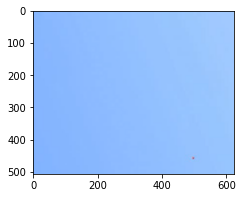

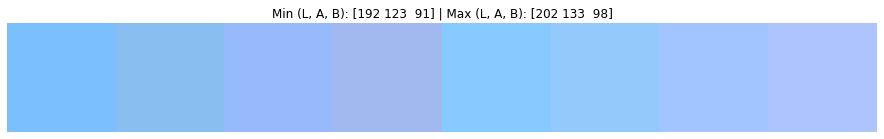

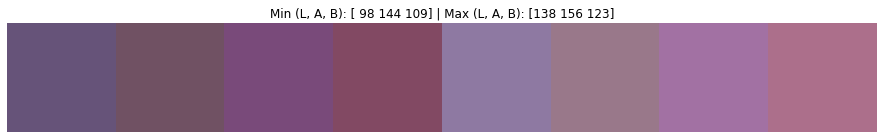

In [4]:
complete_frame, x,y,w,h, contour_mask, identified_object = detect_basic(frame,1,debug=False,debug_image_width=20)

#shrink the contour mask by 1 pixel 
contour_mask = cv2.erode(contour_mask, np.ones((3,3), np.uint8), iterations=1)

background_mask = create_donut_mask_with_exclusion(frame, identified_object,
                                       outer_pad_ratio=2,
                                       exclusion_pad_ratio=1)

show_bgr(frame)
b_min, b_max = get_min_max_lab_values(frame, background_mask)
o_min, o_max = get_min_max_lab_values(frame, contour_mask)

plot_min_max_lab_colors(b_min, b_max)
plot_min_max_lab_colors(o_min, o_max)



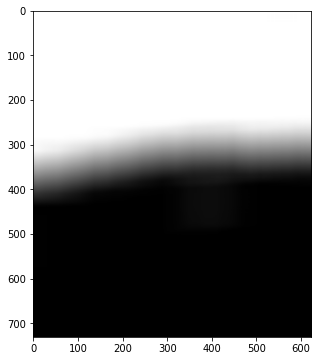

In [9]:
frame = cv2.imread('foi_2b.png')

#scale min values down by 10%
#min_valss = min_vals-10
# decrease second and third values by 10, decrease the first by 20
min_vals_extended = b_min-10

#scale max values up by 10%
#max_vals_double = max_vals+20
# increase second and third values by 10, increase the first by 20
max_vals_extended = b_max+10
m = create_lab_range_mask(frame, min_vals_extended, max_vals_extended)
#gaussian blur m
m = cv2.GaussianBlur(m, (125,125), 100)
#m = m[0:100,500:600]
show_bgr(m, w=10)
#Min L, A, B values: [121 132  96]
#Max L, A, B values: [194 146  99]
